In [45]:
pip install "tensorflow>=2.0.0"

     |████████████████████████████████| 165.1 MB 8.7 kB/s  eta 0:00:01  |█▎                              | 6.8 MB 3.7 MB/s eta 0:00:43     |███████▎                        | 37.6 MB 28.0 MB/s eta 0:00:05     |█████████▉                      | 50.9 MB 10.0 MB/s eta 0:00:12     |███████████████▋                | 80.6 MB 44.4 MB/s eta 0:00:02     |██████████████████▍             | 94.8 MB 44.4 MB/s eta 0:00:02     |███████████████████▊            | 101.9 MB 44.4 MB/s eta 0:00:02     |████████████████████████▏       | 124.6 MB 25.4 MB/s eta 0:00:02     |█████████████████████████████▉  | 153.7 MB 39.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 7.6 MB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 22.9 MB/s eta 0:00:01     |███████████▍                    | 1.1 MB 22.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 459 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████

In [ ]:
!pip install bert-for-tf2

In [40]:
!pip install sentencepiece

In [42]:
!pip install seaborn

     |████████████████████████████████| 283 kB 5.4 MB/s eta 0:00:01


In [46]:
# importing libraries
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

# import bert
# from bert import BertModelLayer
# from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
# from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [193]:
# Read the dataset
import pandas as pd
df = pd.read_csv('DM_Final/winemag-data-130k-v2.csv')

df.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [194]:
# Clean up the data
df = df[['country','description','price','province','title','variety']]
df.head()

,country,description,price,province,title,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",NaN,Sicily & Sardinia,Nicosia 2013 Vulkà Bianco (Etna),White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir


In [195]:
# Remove points with NaN entries
df = df.dropna()
df

,country,description,price,province,title,variety
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir
5,Spain,Blackberry and raspberry aromas show a typical...,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot
...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling
129967,US,Citation is given as much as a decade of bottl...,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir
129968,France,Well-drained gravel soil gives this wine its c...,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer
129969,France,"A dry style of Pinot Gris, this is crisp with ...",32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris


In [196]:
# Get top 5 most popular varieties 
df_variety = df.variety.value_counts()
df_variety.head()

Pinot Noir                  12785
Chardonnay                  11077
Cabernet Sauvignon           9384
Red Blend                    8466
Bordeaux-style Red Blend     5340
Name: variety, dtype: int64

In [197]:
# Get top 5 most popular countires 
df_country = df.country.value_counts()
df_country.head()

US          54265
France      17776
Italy       16914
Spain        6573
Portugal     4875
Name: country, dtype: int64

Text(0.5, 1, 'Country Distribution')

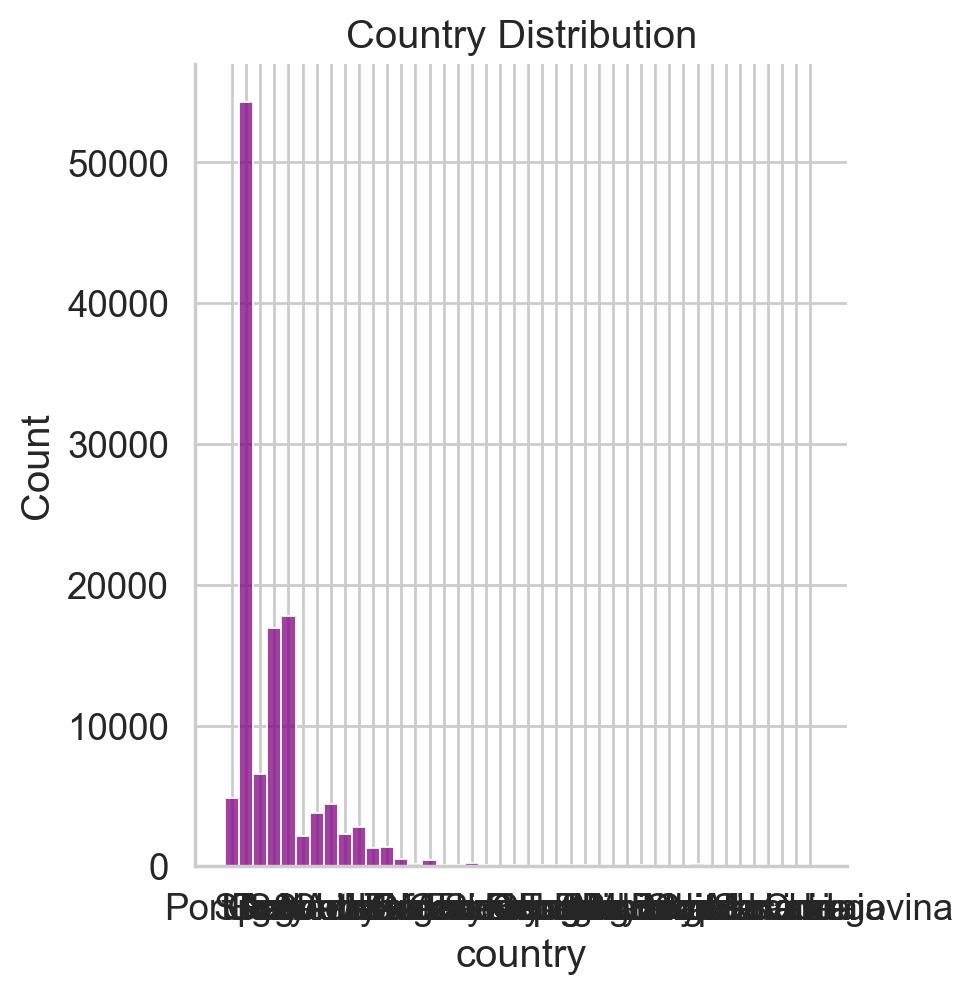

In [162]:
# Country distribution for the entire dataset
# This is not readable -- needs to be fixed
chart = sns.displot(x=df['country'], color = 'purple')
#plt.xlim(0,75)
plt.title("Country Distribution")

In [198]:
# Get top 5 most popular regions 
df_province = df.province.value_counts()
df_province.head()

California    36104
Washington     8583
Oregon         5359
Tuscany        5128
Bordeaux       4002
Name: province, dtype: int64

In [199]:
# Get top 20 most popular price points 
df_price = df.price.value_counts()
df_price.head(20)

20.0    6938
15.0    6066
25.0    5796
30.0    4946
18.0    4881
12.0    3932
40.0    3871
35.0    3801
13.0    3548
16.0    3545
10.0    3439
22.0    3353
50.0    3332
14.0    3214
45.0    3135
17.0    3049
28.0    2938
24.0    2824
19.0    2813
60.0    2277
Name: price, dtype: int64

In [200]:
# Helpful statitics to get a general understanding of price distribution
df['price'].describe()

count    120915.000000
mean         35.368796
std          41.031188
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

Text(0.5, 1, 'Price Distribution')

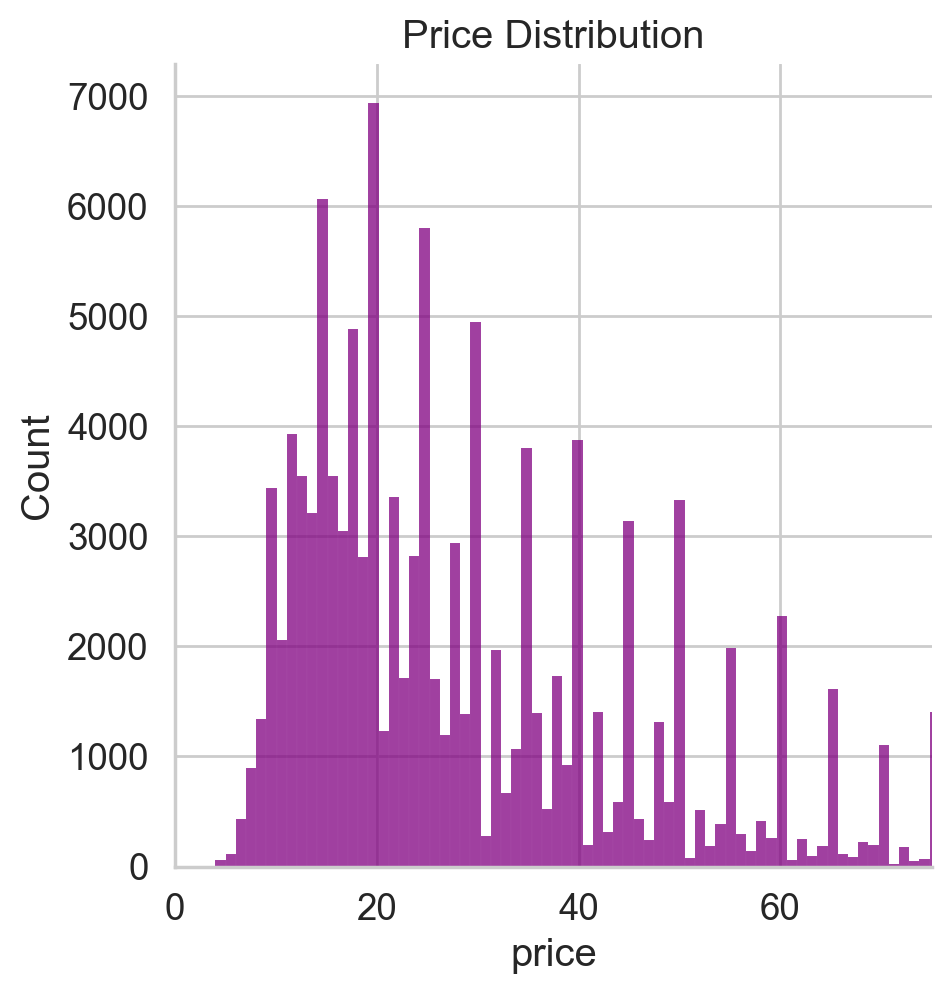

In [201]:
# Price distribution for the entire dataset
chart = sns.displot(x=df['price'], color = 'purple')
plt.xlim(0,75)
plt.title("Price Distribution")

/Users/Nina/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


There are : 0.5962147090203251 % wines more expensive then 200 USD


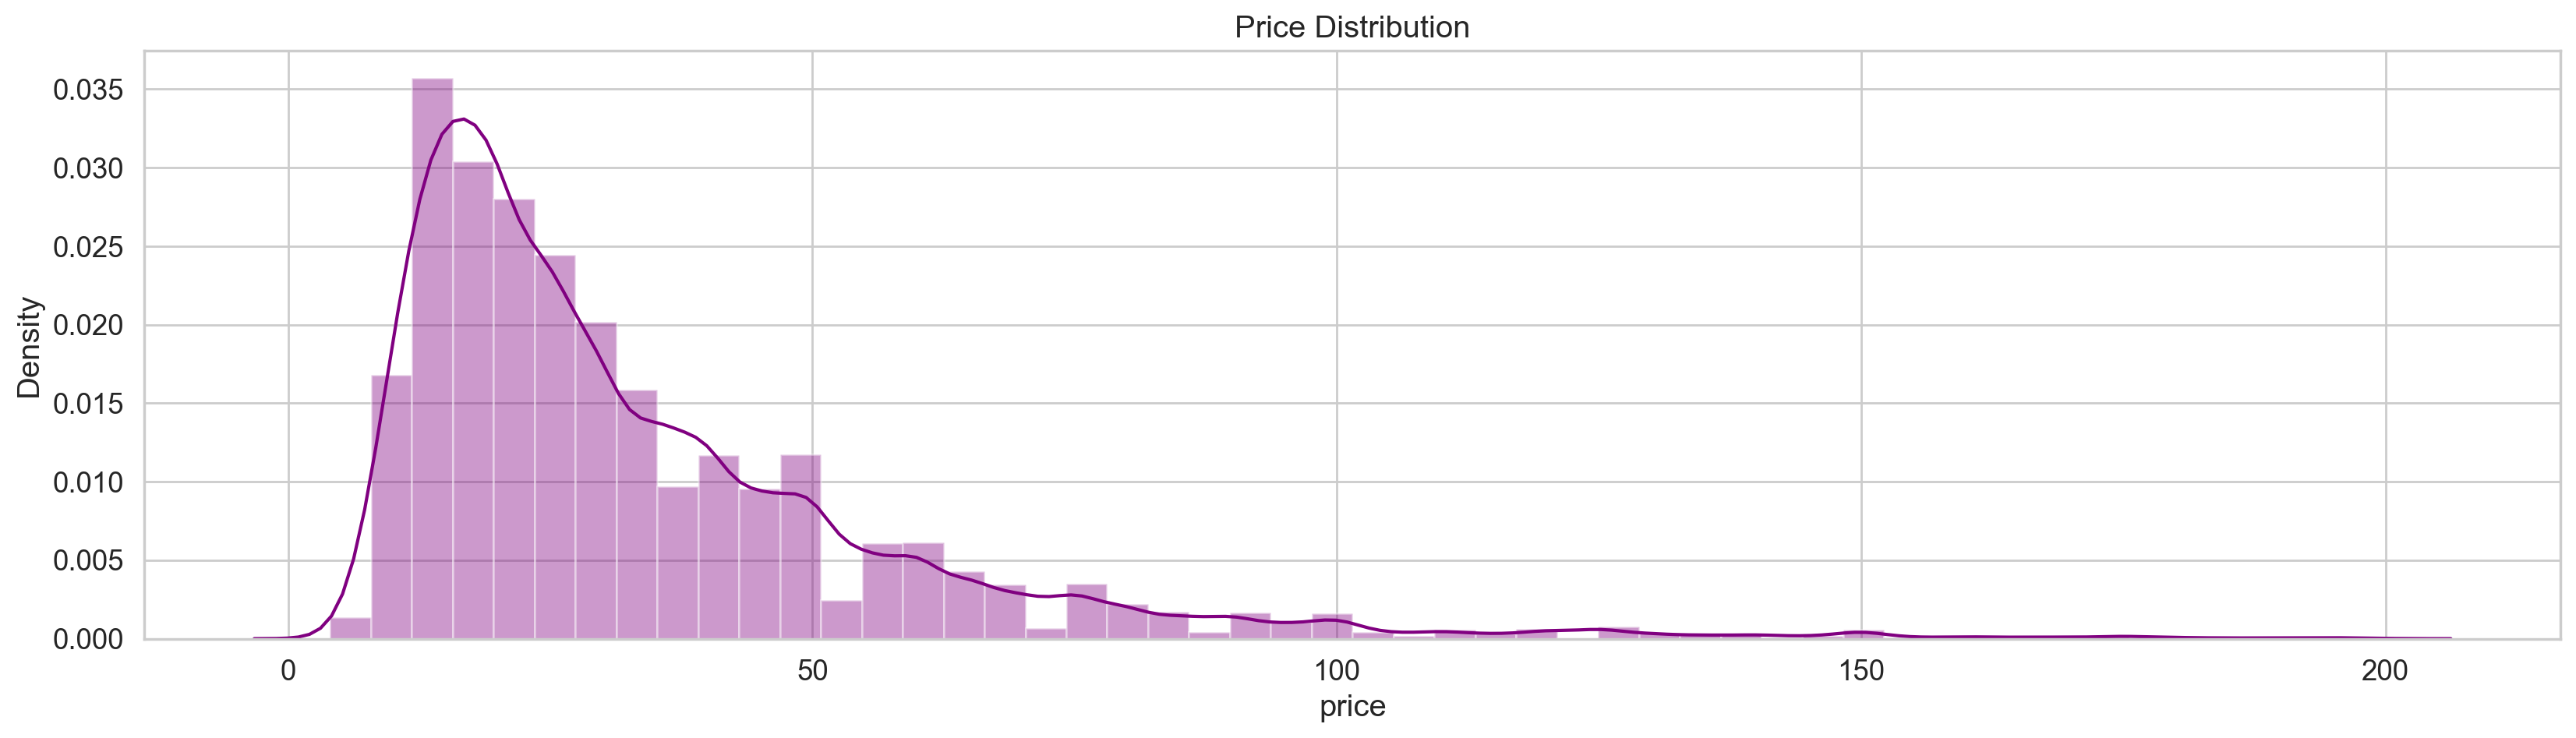

In [192]:
plt.figure(figsize=(20,5))
plt.title("Price Distribution")
chart = sns.distplot(df[df["price"]<200]['price'], color='purple')

percent=df[df['price']>200].shape[0]/df.shape[0]*100
print("There are :", percent, "% wines more expensive then 200 USD")

In [202]:
# Find duplicates
print("Total number of examples: ", df.shape[0])
print("Number of examples with the same title and description: ", df[df.duplicated(['description','title'])].shape[0])

Total number of examples:  120915
Number of examples with the same title and description:  9378


In [203]:
# Remove datapoints with the same title and description
df=df.drop_duplicates(['description','title'])
df=df.reset_index(drop=True)

In [204]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.description, df.variety, test_size = 0.2, random_state = 42)

In [205]:
train = { 'text': X_train, 'intent': y_train }
train_df = pd.DataFrame(train)
test = { 'text': X_test, 'intent': y_test }
test_df = pd.DataFrame(test)

In [206]:
train_df.head()

,text,intent
75127,La Playa does a good job capturing Colchagua's...,Carmenère
50527,From the producer's family estate site planted...,Pinot Noir
42068,"This wine saw no oak barrel aging, but it's so...",Sauvignon Blanc
71764,"A sturdy wine, sporting plenty of roasted cher...",Pinot Noir
67034,Fine Verdejo is more elusive than one might th...,Verdejo


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111537 entries, 0 to 111536
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      111537 non-null  object 
 1   description  111537 non-null  object 
 2   price        111537 non-null  float64
 3   province     111537 non-null  object 
 4   title        111537 non-null  object 
 5   variety      111537 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.1+ MB


In [208]:
df

,country,description,price,province,title,variety
0,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
1,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
2,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
3,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir
4,Spain,Blackberry and raspberry aromas show a typical...,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot
...,...,...,...,...,...,...
111532,Germany,Notes of honeysuckle and cantaloupe sweeten th...,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling
111533,US,Citation is given as much as a decade of bottl...,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir
111534,France,Well-drained gravel soil gives this wine its c...,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer
111535,France,"A dry style of Pinot Gris, this is crisp with ...",32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris


In [210]:
pip install nltk

     |████████████████████████████████| 1.4 MB 3.0 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=9e52ed181f547795ce6dff44e2b87abea4ccf7c7fa254cf5f769675c5751dc07
  Stored in directory: /Users/Nina/Library/Caches/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
Note: you may need to restart the kernel to use updated packages.


In [214]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 4.2 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=160325 sha256=e3f1240cf6fa6e184860e0b1e27ff0f200b66fba844fab843e69f2415497a2e6
  Stored in directory: /Users/Nina/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991
Successfully built wordcloud


In [215]:
# NLP
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string

from wordcloud import WordCloud, STOPWORDS
import re

from nltk.tokenize import RegexpTokenizer

In [216]:
# Text preprocessing

# Lowercasing
df['description']= df['description'].str.lower()
df['description']= df['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  
df['description']

0         this is ripe and fruity  a wine that is smooth...
1         tart and snappy  the flavors of lime flesh and...
2         pineapple rind  lemon pith and orange blossom ...
3         much like the regular bottling from       this...
4         blackberry and raspberry aromas show a typical...
                                ...                        
111532    notes of honeysuckle and cantaloupe sweeten th...
111533    citation is given as much as a decade of bottl...
111534    well drained gravel soil gives this wine its c...
111535    a dry style of pinot gris  this is crisp with ...
111536    big  rich and off dry  this is powered by inte...
Name: description, Length: 111537, dtype: object

In [218]:
# Tokenize sentences to list of words since we can't analyze whole sentences
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['description'].apply(tokenizer.tokenize)
words_descriptions.head()

0    [this, is, ripe, and, fruity, a, wine, that, i...
1    [tart, and, snappy, the, flavors, of, lime, fl...
2    [pineapple, rind, lemon, pith, and, orange, bl...
3    [much, like, the, regular, bottling, from, thi...
4    [blackberry, and, raspberry, aromas, show, a, ...
Name: description, dtype: object

In [219]:
# Create a vocabulary
all_words = [word for tokens in words_descriptions for word in tokens]
df['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

4622533 words total, with a vocabulary size of 29476


In [220]:
# Check most commonly used words
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('and', 302742),
 ('the', 190741),
 ('a', 154743),
 ('of', 149729),
 ('with', 104056),
 ('this', 97956),
 ('is', 81880),
 ('it', 74605),
 ('wine', 66673),
 ('flavors', 55583),
 ('in', 55146),
 ('to', 48436),
 ('s', 46888),
 ('fruit', 42615),
 ('on', 40202),
 ('that', 34349),
 ('aromas', 34255),
 ('palate', 33538),
 ('finish', 30946),
 ('acidity', 28921),
 ('from', 27765),
 ('but', 27551),
 ('tannins', 25870),
 ('drink', 25687),
 ('cherry', 25557),
 ('black', 24914),
 ('are', 22553),
 ('ripe', 22535),
 ('has', 20389),
 ('for', 19011),
 ('red', 18588),
 ('by', 17474),
 ('notes', 16612),
 ('spice', 16206),
 ('oak', 16018),
 ('an', 15664),
 ('as', 15501),
 ('its', 15191),
 ('dry', 15037),
 ('now', 14952),
 ('nose', 14949),
 ('rich', 14686),
 ('berry', 14525),
 ('fresh', 14494),
 ('full', 13624),
 ('plum', 13066),
 ('sweet', 11813),
 ('apple', 11635),
 ('blend', 11570),
 ('soft', 11557),
 ('well', 11314),
 ('blackberry', 11310),
 ('white', 11003),
 ('fruits', 10842),
 ('light', 10835),
 ('

In [224]:
# Download a list of commonly used stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Nina/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [225]:
# Stopword removal
stopword_list = stopwords.words('english')
ps = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda elem: [word for word in elem if not word in stopword_list])
words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])
df['processed_description'] = words_descriptions.apply(lambda elem: ' '.join(elem))

In [226]:
all_words = [word for tokens in words_descriptions for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
count_all_words = Counter(all_words)
count_all_words.most_common(100)

# Deleted around 8k words

2820894 words total, with a vocabulary size of 21063


[('wine', 69089),
 ('flavor', 62638),
 ('fruit', 53822),
 ('finish', 35823),
 ('aroma', 35526),
 ('palat', 33649),
 ('acid', 33313),
 ('cherri', 29476),
 ('drink', 28900),
 ('tannin', 27704),
 ('black', 24941),
 ('ripe', 24034),
 ('dri', 22833),
 ('note', 21882),
 ('spice', 20035),
 ('red', 18806),
 ('rich', 18377),
 ('fresh', 18082),
 ('berri', 16563),
 ('oak', 16553),
 ('show', 15938),
 ('nose', 14963),
 ('plum', 14240),
 ('sweet', 13919),
 ('full', 13724),
 ('offer', 13692),
 ('blackberri', 13386),
 ('textur', 13368),
 ('blend', 13270),
 ('appl', 13137),
 ('bodi', 12997),
 ('balanc', 12996),
 ('soft', 12039),
 ('age', 11715),
 ('crisp', 11398),
 ('well', 11325),
 ('light', 11144),
 ('white', 11143),
 ('dark', 10648),
 ('structur', 10641),
 ('citru', 10099),
 ('raspberri', 9906),
 ('cabernet', 9853),
 ('vanilla', 9822),
 ('hint', 9748),
 ('herb', 9713),
 ('miner', 9666),
 ('fruiti', 9651),
 ('bright', 9372),
 ('give', 9220),
 ('pepper', 9125),
 ('touch', 8878),
 ('year', 8657),
 ('gr

<FreqDist with 21063 samples and 2820894 outcomes>


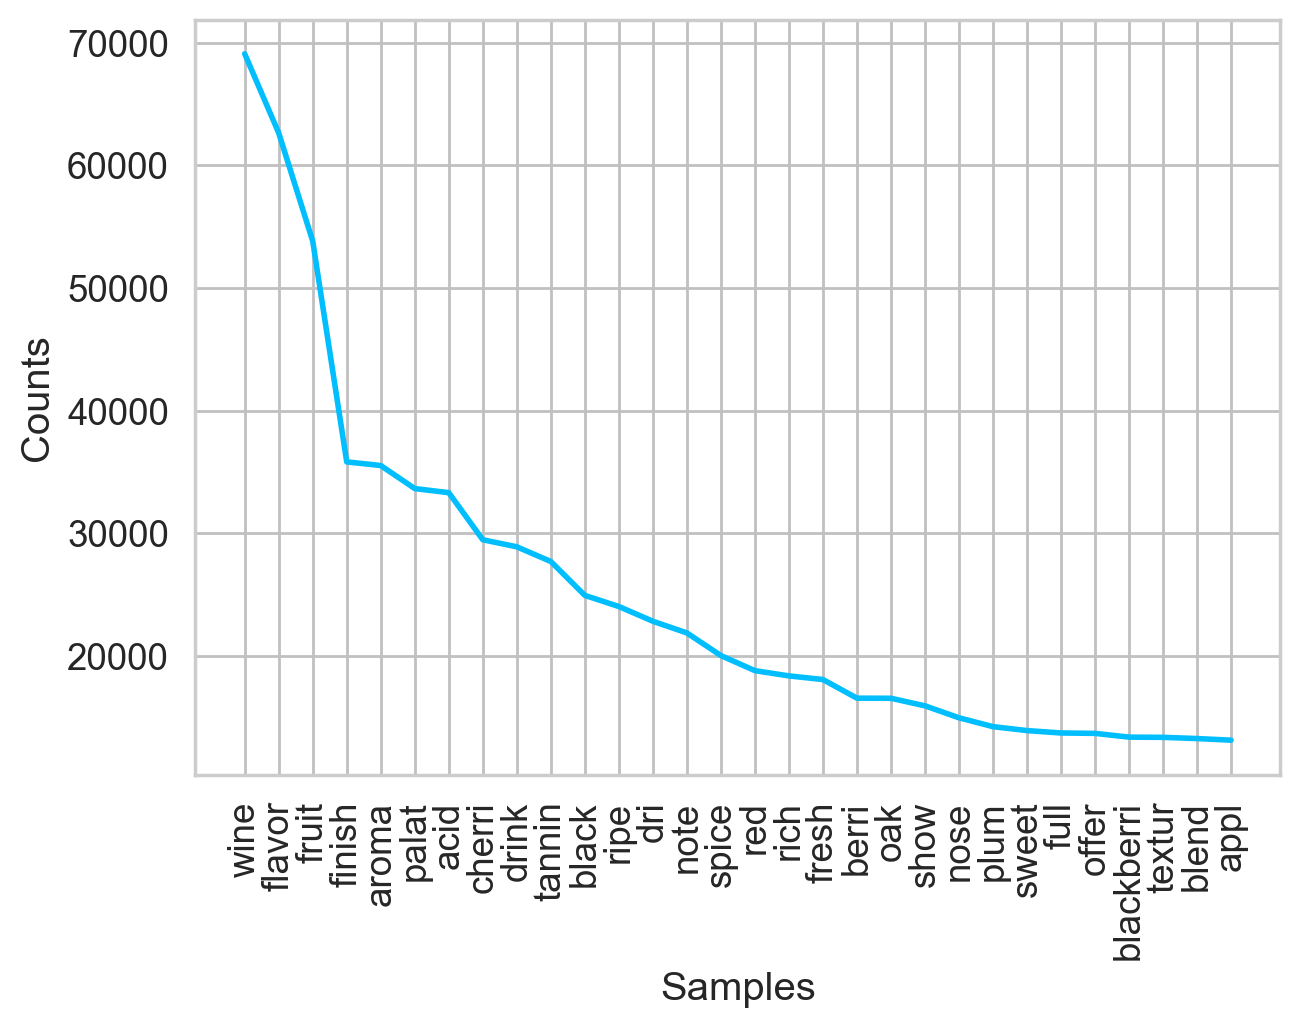

In [267]:
from nltk.probability import FreqDist
fdist = FreqDist(all_words)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()